# Exploratory analysis of arbitrage data collected on Binance during one-day proof of concept run
### Importing libraries

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import sqlite3
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
import plotly.express as px

### Loading and Preprocessing Data from SQLite Database

In [2]:
# Connect to the SQLite database
conn = sqlite3.connect('data.db')
c = conn.cursor()

# Read profit durations from the profit_durations table
query = "SELECT name, base_currency, duration, starting_profit FROM profit_durations"
profit_durations_df = pd.read_sql_query(query, conn)
# Convert duration from nanoseconds to seconds for easier readability
profit_durations_df["duration"] = profit_durations_df["duration"] / 1e9

# Read data from the arbitrage_correlation table
query = "SELECT arbitrage_num, duration, profit, volatility, volume FROM arbitrage_correlation"
correlation_df = pd.read_sql_query(query, conn)
# Fill any NaN values with 0
correlation_df.fillna(0, inplace=True)
# Convert duration from nanoseconds to seconds for easier readability
correlation_df["duration"] = correlation_df["duration"] / 1e9
# Filter out rows where volume or volatility is 0 to avoid division by zero
correlation_df = correlation_df.loc[(correlation_df['volume'] != 0) & (correlation_df['volatility'] != 0)]


# Close the database connection
conn.close()

### Profit Durations by Base Currency

Base Currency: USDT


,duration,starting_profit
count,256068.000,256068.000
mean,0.437,0.190
std,1.273,0.286
min,0.000,0.000
25%,0.009,0.042
50%,0.057,0.109
75%,0.301,0.238
max,73.299,29.485


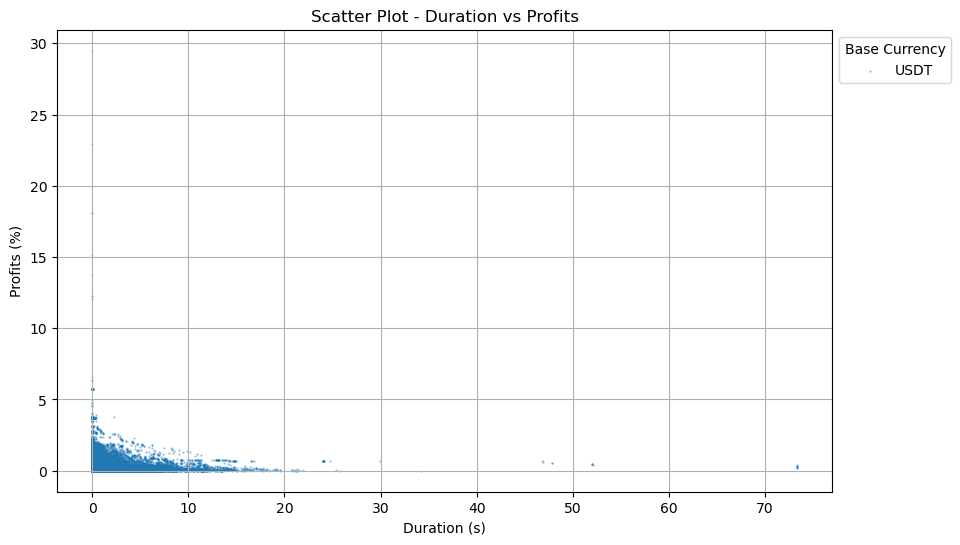

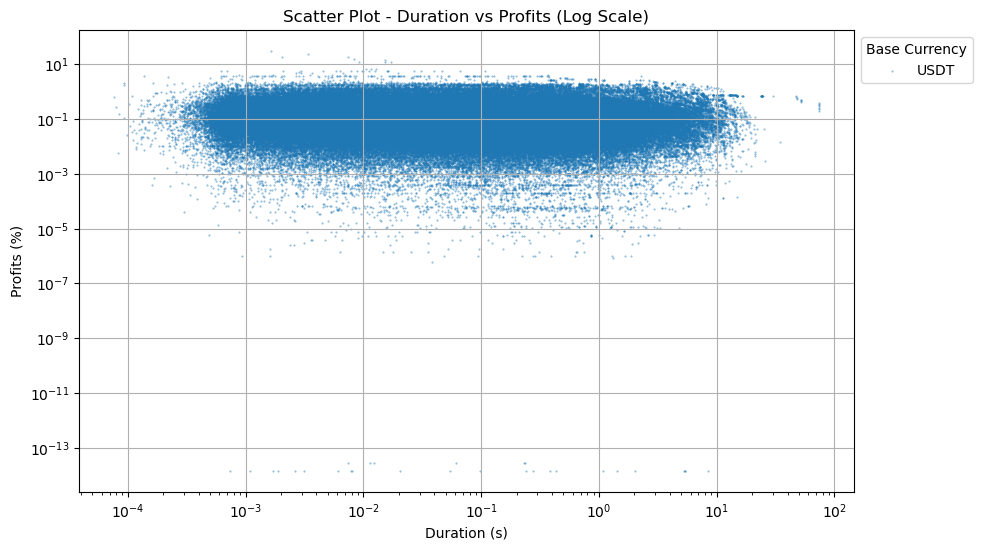

In [3]:
# Loop through unique currencies
for currency in profit_durations_df['base_currency'].unique():
    currency_df = profit_durations_df[profit_durations_df['base_currency'] == currency]
    description = currency_df.describe().style.format(precision=3)
    print(f"Base Currency: {currency}")
    display(description)

# Create the scatter plot for linear scale
plt.figure(figsize=(10, 6))
for currency in profit_durations_df['base_currency'].unique():
    currency_df = profit_durations_df[profit_durations_df['base_currency'] == currency]
    # Scatter plot for duration vs starting profit
    plt.scatter(currency_df['duration'], currency_df['starting_profit'], label=currency, alpha=0.5, marker=".", s=1)
plt.xlabel('Duration (s)')
plt.ylabel('Profits (%)')
plt.title('Scatter Plot - Duration vs Profits')
plt.legend(title='Base Currency', loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

# Create the scatter plot for log-log scale
plt.figure(figsize=(10, 6))
for currency in profit_durations_df['base_currency'].unique():
    currency_df = profit_durations_df[profit_durations_df['base_currency'] == currency]
    # Scatter plot for duration vs starting profit with log-log scale
    plt.scatter(currency_df['duration'], currency_df['starting_profit'], label=currency, alpha=0.5, marker=".", s=1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Duration (s)')
plt.ylabel('Profits (%)')
plt.title('Scatter Plot - Duration vs Profits (Log Scale)')
plt.legend(title='Base Currency', loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

### Profit Durations by Base Currency with Outlier Removal

Base Currency: USDT


,duration,starting_profit
count,255554.000,255548.000
mean,0.419,0.186
std,1.080,0.242
min,0.000,0.000
25%,0.009,0.042
50%,0.057,0.109
75%,0.299,0.237
max,13.009,2.329


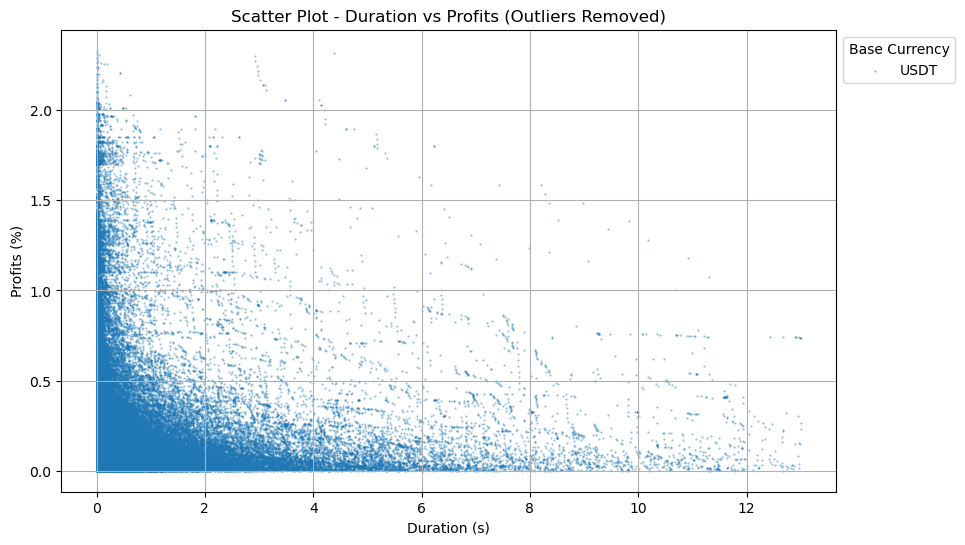

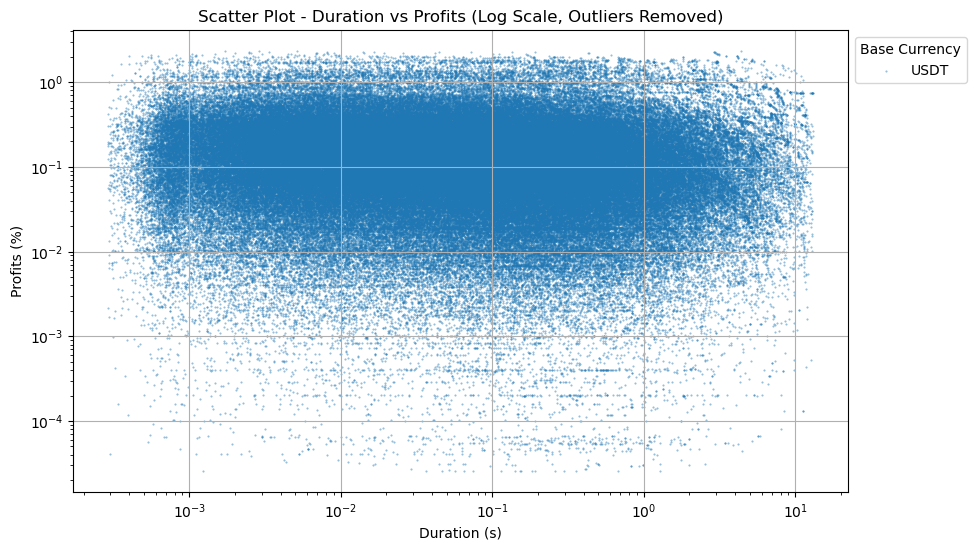

In [4]:
# Define lower and upper quantiles for outlier removal
lower_quantile = 0.001
upper_quantile = 0.999

# Filter columns with numerical data
numeric_cols = profit_durations_df.select_dtypes(include=[np.number]).columns
# Create a copy of the DataFrame for filtering outliers
profit_durations_df_filtered = profit_durations_df.copy()

# Remove outliers from numerical columns
profit_durations_df_filtered[numeric_cols] = profit_durations_df[numeric_cols].apply(lambda x: x[(x > x.quantile(lower_quantile)) & (x < x.quantile(upper_quantile))], axis=0)

# Loop through unique base currencies in the filtered DataFrame
for currency in profit_durations_df_filtered['base_currency'].unique():
    currency_df = profit_durations_df_filtered[profit_durations_df_filtered['base_currency'] == currency]
    description = currency_df.describe().style.format(precision=3)
    print(f"Base Currency: {currency}")
    display(description)

# Create a scatter plot for linear scale without outliers
plt.figure(figsize=(10, 6))
for currency in profit_durations_df_filtered['base_currency'].unique():
    currency_df = profit_durations_df_filtered[profit_durations_df_filtered['base_currency'] == currency]
    plt.scatter(currency_df['duration'], currency_df['starting_profit'], label=currency, alpha=0.5, marker=".", s=1)
plt.xlabel('Duration (s)')
plt.ylabel('Profits (%)')
plt.title('Scatter Plot - Duration vs Profits (Outliers Removed)')
plt.legend(title='Base Currency', loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

# Create a scatter plot for log-log scale without outliers
plt.figure(figsize=(10, 6))
for currency in profit_durations_df_filtered['base_currency'].unique():
    currency_df = profit_durations_df_filtered[profit_durations_df_filtered['base_currency'] == currency]
    plt.scatter(currency_df['duration'], currency_df['starting_profit'], label=currency, alpha=0.5, marker=".", s=1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Duration (s)')
plt.ylabel('Profits (%)')
plt.title('Scatter Plot - Duration vs Profits (Log Scale, Outliers Removed)')
plt.legend(title='Base Currency', loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

### Analysis of Top Chains with the Highest Number of Arbitrage Opportunities

Top 20 chains:
FDUSDUSDT DOGEFDUSD DOGEUSDT: 41660
DOGEUSDT DOGEFDUSD FDUSDUSDT: 36240
DOGEUSDT DOGEEUR EURUSDT: 14195
DOGEUSDT SHIBDOGE SHIBUSDT: 13937
FDUSDUSDT FLOKIFDUSD FLOKIUSDT: 12797
DOGEUSDT DOGETUSD TUSDUSDT: 9549
TUSDUSDT DOGETUSD DOGEUSDT: 6300
EURUSDT DOGEEUR DOGEUSDT: 5848
USDTTRY DOGETRY DOGEUSDT: 5517
SHIBUSDT SHIBDOGE DOGEUSDT: 4997
DOGEUSDT DOGEBRL USDTBRL: 4422
DOGEUSDT DOGETRY USDTTRY: 3719
USDTTRY LPTTRY LPTUSDT: 3505
FDUSDUSDT PEPEFDUSD PEPEUSDT: 2993
USDTTRY AMPTRY AMPUSDT: 2951
SOLUSDT SOLFDUSD FDUSDUSDT: 2232
BTCUSDT BTCFDUSD FDUSDUSDT: 2179
APTUSDT APTFDUSD FDUSDUSDT: 2154
FDUSDUSDT BTCFDUSD BTCUSDT: 1960
USDTTRY WAVESTRY WAVESUSDT: 1945
Other: 76968


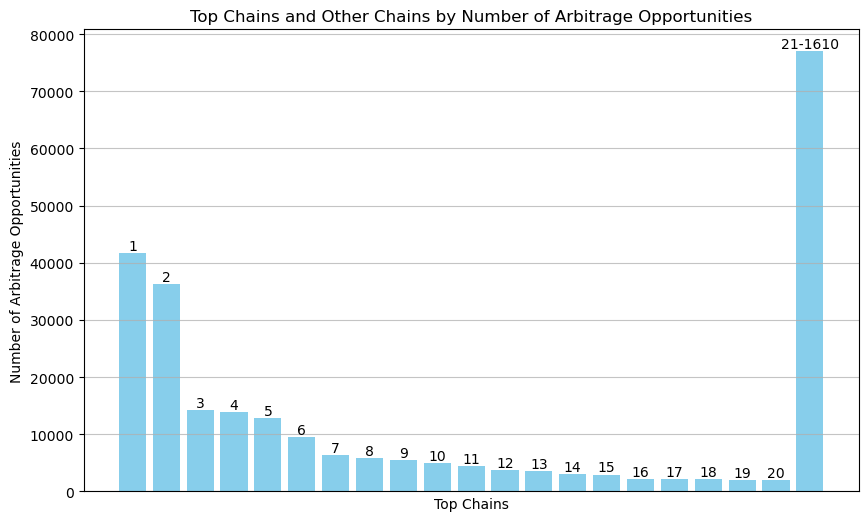

In [5]:
# Set the number of top chains to display
top_n = 20

# Count the number of occurrences of each chain name
name_counts = profit_durations_df['name'].value_counts()

# Get the top chains with the highest number of arbitrage opportunities
top_chains = name_counts.nlargest(top_n)
# Calculate the total number of opportunities for chains not in the top n
other_opportunities = name_counts.sum() - top_chains.sum()
other_chains = pd.Series({'Other': other_opportunities})

# Concatenate the top chains with the 'Other' chain
top_chains = pd.concat([top_chains, other_chains])

# Create labels for the top chains and "Other"
chain_labels = [f"{i+1}" for i in range(top_n)] + [f"{top_n+1}-1610"]

# Print the top n names
print(f"Top {len(top_chains) - 1} chains:")
for chain, count in top_chains.items():
    print(f"{chain}: {count}")

# Plotting a bar chart of the top chains with the highest number of arbitrage opportunities
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(top_chains)), top_chains.values, color='skyblue')

# Hide x-axis ticks
plt.xticks([])

plt.xlabel('Top Chains')
plt.ylabel('Number of Arbitrage Opportunities')
plt.title('Top Chains and Other Chains by Number of Arbitrage Opportunities')
plt.grid(axis='y', alpha=0.75)

# Add labels to the bars
for bar, label in zip(bars, chain_labels):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, label, ha='center', va='bottom')

plt.show()

### Analysis of Top Symbols in Chain Names with the Highest Number of Arbitrage Opportunities

Top 20 symbols:
DOGEUSDT: 147948
FDUSDUSDT: 125132
DOGEFDUSD: 77900
USDTTRY: 34443
EURUSDT: 24257
SHIBUSDT: 22308
TUSDUSDT: 20749
DOGEEUR: 20043
SHIBDOGE: 18934
BTCUSDT: 17817
DOGETUSD: 15849
FLOKIUSDT: 14142
FLOKIFDUSD: 14034
DOGETRY: 9236
USDCUSDT: 7137
USDTBRL: 6744
DOGEBRL: 5851
ETHUSDT: 5364
LPTUSDT: 5064
LPTTRY: 4970
Other: 170282


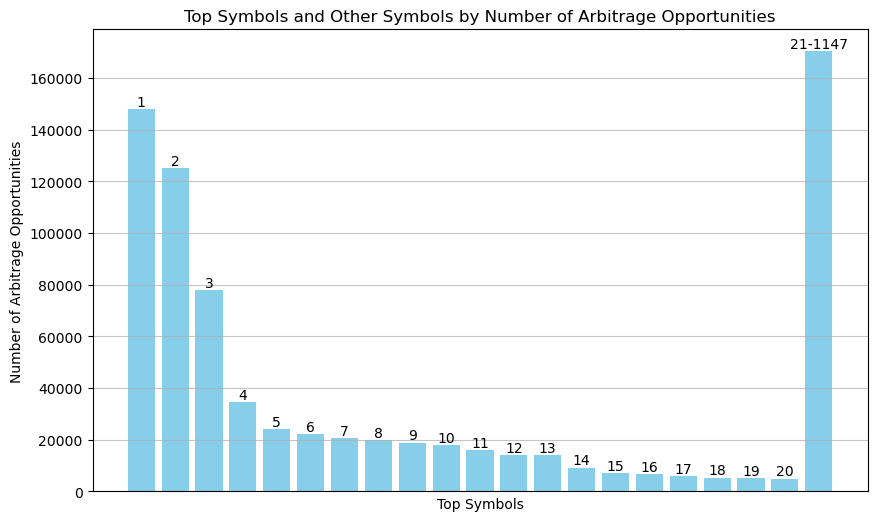

In [6]:
# Split each full chain name into individual symbols and flatten the list
symbols = profit_durations_df['name'].str.split().explode()

# Count the occurrences of each symbol
symbol_counts = symbols.value_counts()

# Set the number of top symbols to display
top_n = 20

# Get the top symbols with the highest number of occurrences
top_symbols = symbol_counts.nlargest(top_n)
# Calculate the total number of opportunities for symbols not in the top n
other_opportunities = symbol_counts.sum() - top_symbols.sum()
other_symbols = pd.Series({'Other': other_opportunities})

# Concatenate the top symbols with the 'Other' symbol
top_symbols = pd.concat([top_symbols, other_symbols])

# Create labels for the top symbols and "Other"
symbol_labels = [f"{i+1}" for i in range(top_n)] + [f"{top_n+1}-1147"]

# Print the top n symbols
print(f"Top {len(top_symbols) - 1} symbols:")
for symbol, count in top_symbols.items():
    print(f"{symbol}: {count}")

# Plot a bar chart of the top symbols with the highest number of occurrences
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(top_symbols)), top_symbols.values, color='skyblue')

# Hide x-axis ticks
plt.xticks([])

plt.xlabel('Top Symbols')
plt.ylabel('Number of Arbitrage Opportunities')
plt.title('Top Symbols and Other Symbols by Number of Arbitrage Opportunities')
plt.grid(axis='y', alpha=0.75)

# Add labels to the bars
for bar, label in zip(bars, symbol_labels):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, label, ha='center', va='bottom')

plt.show()

### Analysis of Longest Profit Trajectories from SQLite Database

In [9]:
# Connect to the SQLite database
conn = sqlite3.connect('data.db')
c = conn.cursor()

# Read profit trajectories from the profit_trajectories table
c.execute("SELECT trajectory FROM profit_trajectories")
rows = c.fetchall()
profit_trajectories = []
for row in rows:
    trajectory_json = row[0]
    trajectory = json.loads(trajectory_json)
    profit_trajectories.append(trajectory)

# Close the database connection
conn.close()

# Function to extract x and y values from each trajectory
def extract_values(trajectory):
    x = [point[0] for point in trajectory]
    y = [point[1] for point in trajectory]
    return x, y

# Initialize lists to store data for plotting
plot_data = {'x_seconds': [], 'y': [], 'trajectory': []}

# Sort trajectories based on the last value in x_seconds
sorted_trajectories = sorted(
    enumerate(profit_trajectories),
    key=lambda t: np.array(extract_values(t[1])[0])[-1] / 1e9,
    reverse=True
)

# Extract and plot data from the 10 longest trajectories
count = 0
for i, trajectory in sorted_trajectories:
    x, y = extract_values(trajectory)
    if y[0] >= 1 and count < 10:
        # Convert nanoseconds to seconds
        x_seconds = np.array(x) / 1e9
        plot_data['x_seconds'].extend(x_seconds)
        plot_data['y'].extend(y)
        plot_data['trajectory'].extend([f'Trajectory {i+1}'] * len(x_seconds))
        count += 1

# Create DataFrame from the plot data
df = pd.DataFrame(plot_data)
print(df.describe())

# Calculate the fraction of zeros in the y coordinate
fraction_zeros = np.count_nonzero(df['y'] == 0) / len(df['y'])
print(f'Fraction of zeros in y coordinate: {fraction_zeros}')

# Create scatter plot with lines connecting the dots
fig = px.line(df, x='x_seconds', y='y', color='trajectory', title='Profit Trajectories',
              labels={'x_seconds': 'Time (seconds)', 'y': 'Profit (%)'},
              line_group='trajectory', markers=True)

# Remove legend
fig.update_layout(showlegend=False)

# Show the plot
fig.show()

# Clear the profit_trajectories variable from memory
%reset_selective -f profit_trajectories, rows, sorted_trajectories

         x_seconds            y
count  9361.000000  9361.000000
mean      6.104023     0.423900
std       3.000330     0.599620
min       0.000000     0.000000
25%       3.619923     0.000000
50%       7.028555     0.000000
75%       8.440078     1.163033
max      11.301170     1.485200
Fraction of zeros in y coordinate: 0.663177011003098


### Analysis of Correlation Data with Outlier Removal

,arbitrage_num,duration,profit,volatility,volume
count,1460.0000,1460.0000,1460.0000,1460.0000,1.460000e+03
mean,170.8205,0.2505,0.1296,0.0012,1.970307e+07
std,611.3628,0.4895,0.2628,0.0006,1.208979e+07
min,0.0000,0.0000,0.0000,0.0000,3.079015e+02
25%,1.0000,0.0021,0.0178,0.0009,1.300125e+07
50%,13.0000,0.0525,0.0709,0.0010,1.671056e+07
75%,113.0000,0.3711,0.1407,0.0013,2.298174e+07
max,8146.0000,9.1115,5.8491,0.0053,1.032044e+08


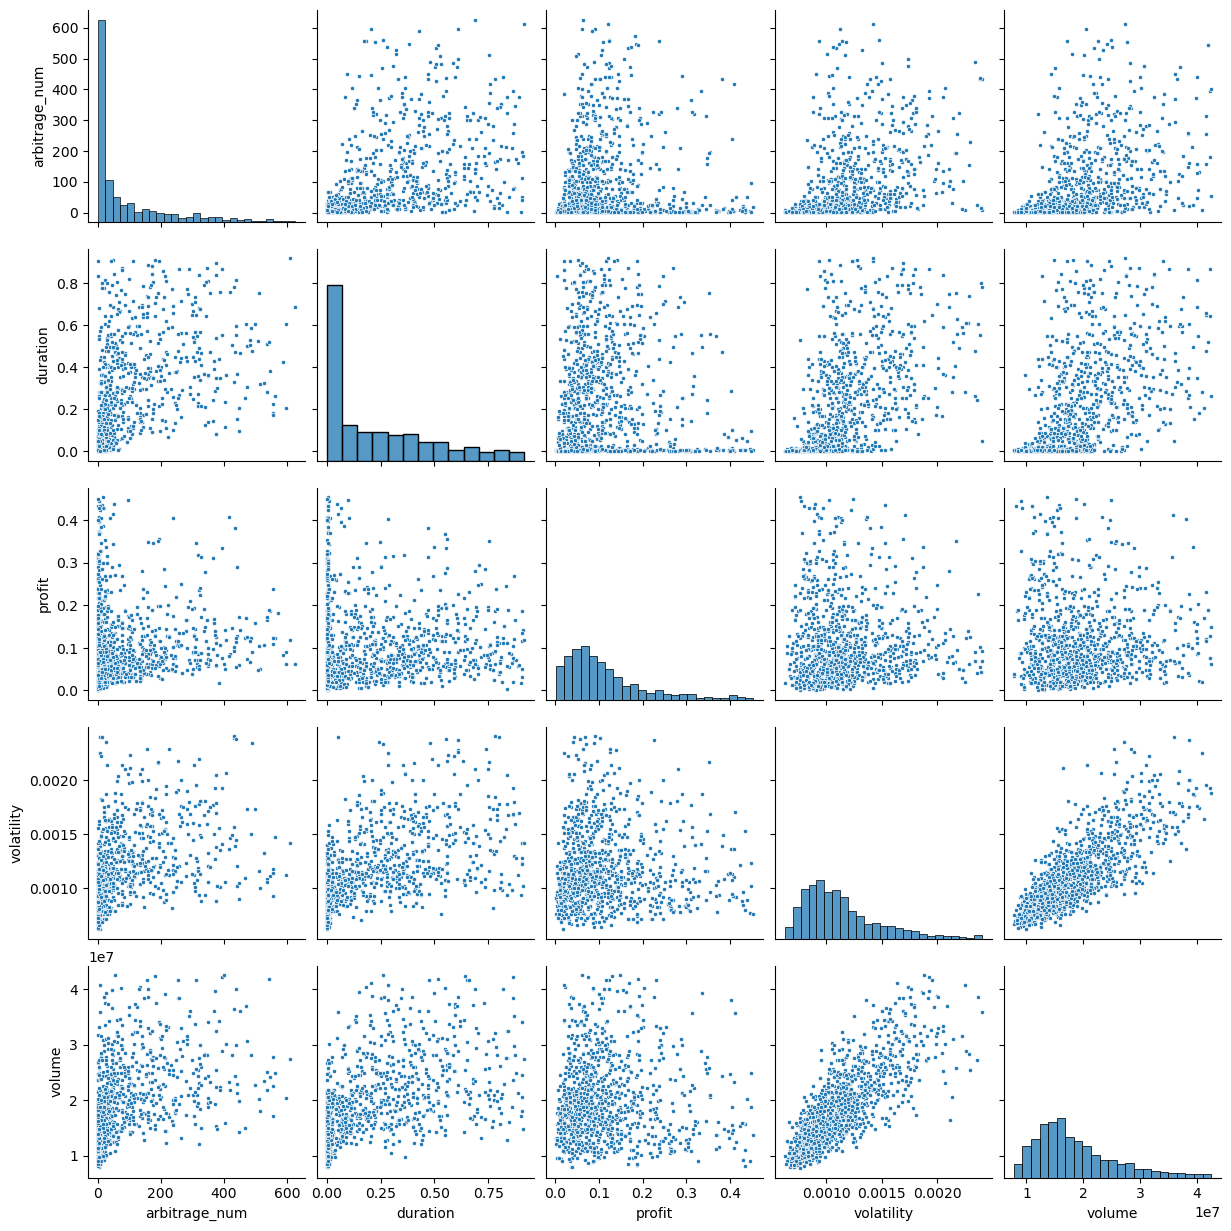

In [ ]:
# Display descriptive statistics for the correlation data
display(correlation_df.describe().apply(lambda x: round(x, 4)))

# Define the lower and upper quantiles for outlier removal (e.g., 5th and 95th percentiles)
lower_quantile = 0.05
upper_quantile = 0.95

# Remove outliers from the correlation data
data_filtered = correlation_df.apply(lambda x: x[(x > x.quantile(lower_quantile)) & (x < x.quantile(upper_quantile))], axis=0)

# Create a pairplot of the filtered data
sns.pairplot(data_filtered, markers=".")
plt.show()

### Visualizing the Correlation Matrix of Triangular Arbitrage Data

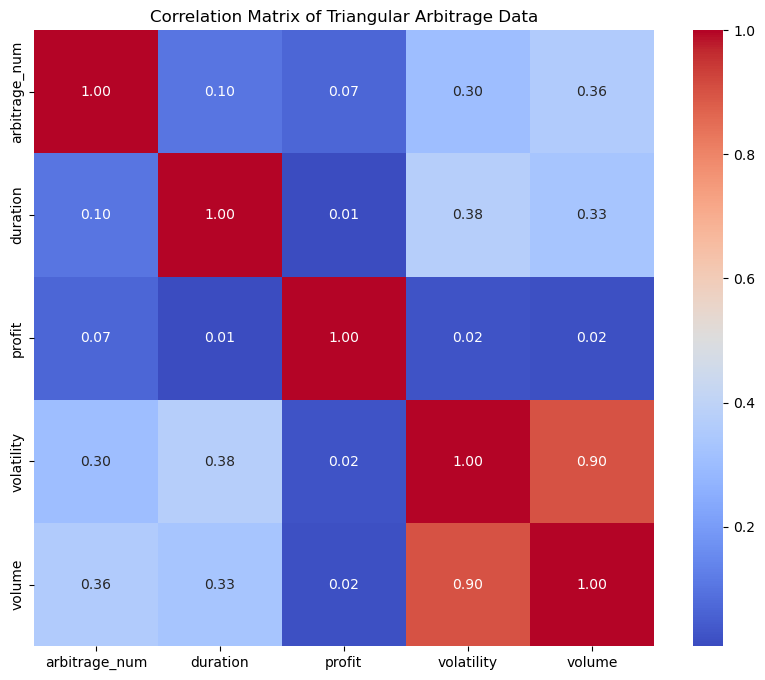

In [ ]:
# Calculate the Pearson correlation coefficient
correlation_matrix = correlation_df.corr()

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Triangular Arbitrage Data')
plt.show()

### Visualizing the Spearman Rank Correlation Matrix of Triangular Arbitrage Data

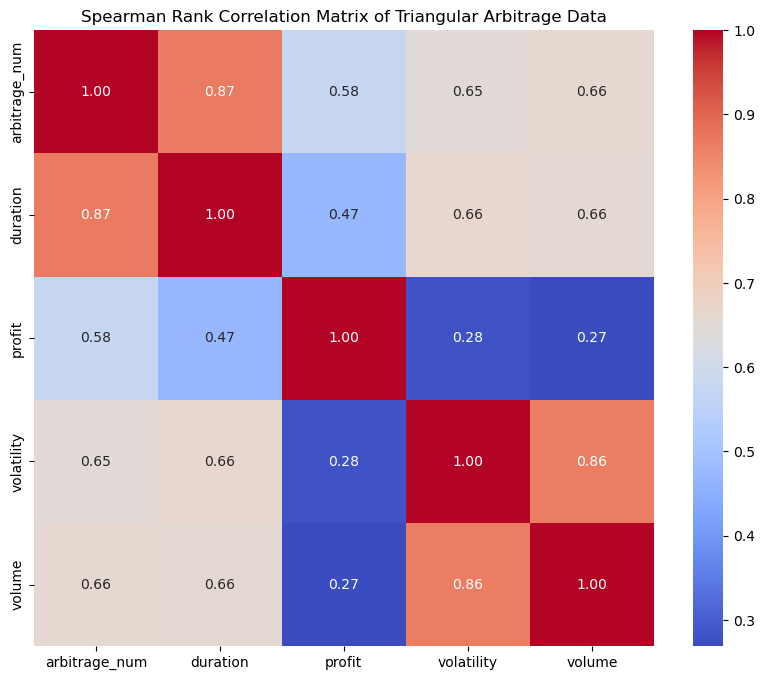

In [ ]:
# Calculate the Spearman rank correlation coefficient
spearman_corr_matrix = correlation_df.corr(method='spearman')

# Visualize the Spearman rank correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(spearman_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Spearman Rank Correlation Matrix of Triangular Arbitrage Data')
plt.show()

### Visualizing Autocorrelation of Triangular Arbitrage Data

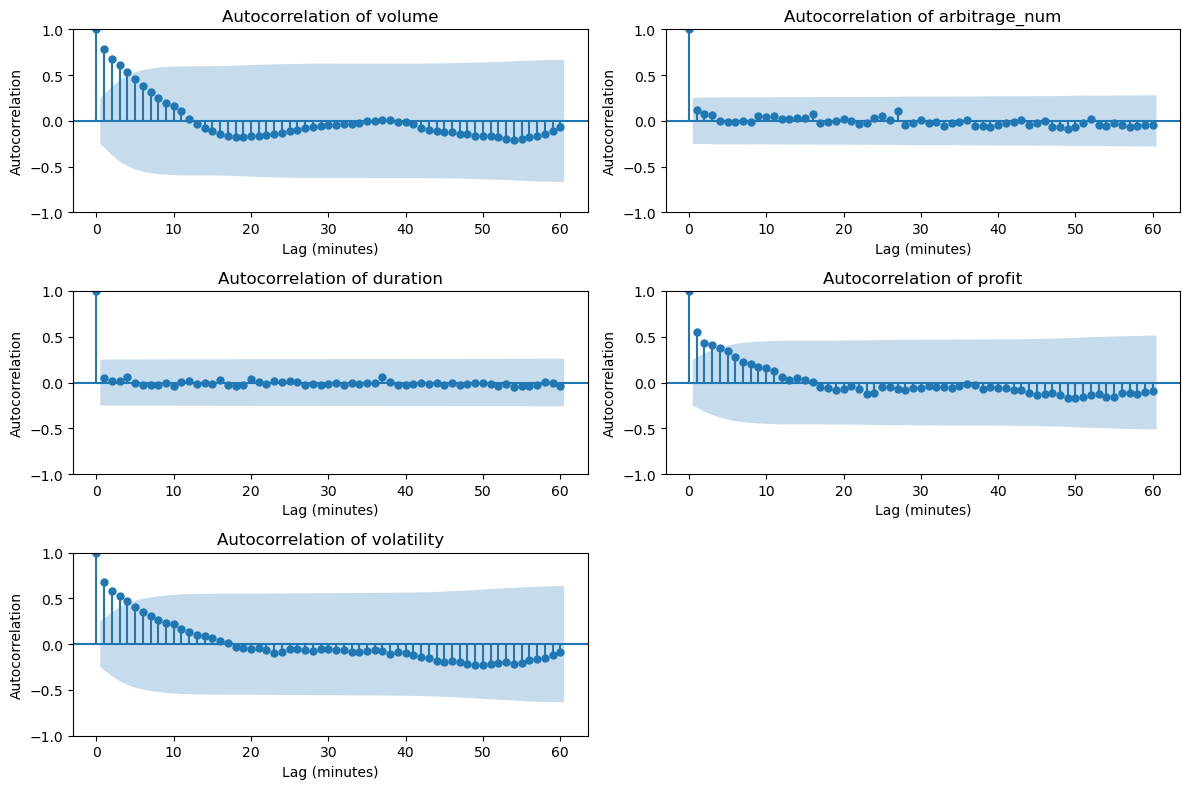

In [ ]:
# Calculate autocorrelation for each variable
autocorr_results = {}
for col in correlation_df.columns:
    autocorr_results[col] = [correlation_df[col].autocorr(lag) for lag in range(0, 61)]  # Assuming 60 minutes in an hour

# Visualize autocorrelation for each variable as correlograms
num_plots = len(correlation_df.columns)
num_cols = 2  # Number of columns for subplots
num_rows = (num_plots + 1) // num_cols  # Calculate number of rows needed, rounding up

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 8))

for i, (col, autocorrs) in enumerate(autocorr_results.items()):
    row = i // num_cols
    col = i % num_cols
    plot_acf(autocorrs, lags=60, ax=axs[row, col])  # Adjust the number of lags as needed
    axs[row, col].set_xlabel('Lag (minutes)')
    axs[row, col].set_ylabel('Autocorrelation')
    axs[row, col].set_title(f'Autocorrelation of {correlation_df.columns[i - 1]}')

# Remove any unused subplots
for i in range(num_plots, num_rows * num_cols):
    fig.delaxes(axs.flatten()[i])

plt.tight_layout()
plt.show()